<a href="https://colab.research.google.com/github/Karthick47v2/mock-buddy/blob/base-dev/300w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libs

In [1]:
import glob
import pandas as pd
import numpy as np
import scipy.io
import cv2
import matplotlib.pyplot as plt
from itertools import chain
import os
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

## Connect to GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## Extract dataset

In [ ]:
# afw
!mkdir afw
!unzip /content/gdrive/MyDrive/300w/afw.zip -d afw/

# # ibug
!mkdir ibug
!unzip /content/gdrive/MyDrive/300w/ibug.zip -d ibug/

# # helen
!mkdir helen
!unzip /content/gdrive/MyDrive/300w/helen.zip -d helen/

# # lfpw
!mkdir lfpw
!unzip /content/gdrive/MyDrive/300w/lfpw.zip -d lfpw/

# bounding box region
!mkdir bb
!unzip /content/gdrive/MyDrive/300w/bounding_boxes.zip -d bb/

## Read data

In [4]:
def read_mat(filename):
  mat = scipy.io.loadmat(f"bb/Bounding Boxes/{filename}.mat")
  if filename == 'bounding_boxes_ibug':
    return mat['bounding_boxes'][0][0:135]
  return mat['bounding_boxes'][0]

def read_pts(filepath):
  return np.loadtxt(filepath, comments=("version:", "n_points:", "{", "}"))

def get_lm(dataset, img_name):
  return list(map(lambda x: read_pts(f"{dataset}/{x.split('.')[0]}.pts"), img_name))

def mat_to_pd(filename, dataset):
  mat = read_mat(filename)
  path, name, bb = zip(*[(f"/content/{dataset}/{x['imgName'][0][0][0]}", x['imgName'][0][0][0], 
                          x['bb_ground_truth'][0][0][0]) for x in mat])

  return pd.DataFrame({'path': path, 'name': name, 'bb': bb, 'lm': get_lm(dataset, name)})

afw_pd = mat_to_pd('bounding_boxes_afw', 'afw')
ibug_pd = mat_to_pd('bounding_boxes_ibug', 'ibug')
helen_train_pd = mat_to_pd('bounding_boxes_helen_trainset', 'helen/trainset')
helen_test_pd = mat_to_pd('bounding_boxes_helen_testset', 'helen/testset')
lfpw_train_pd = mat_to_pd('bounding_boxes_lfpw_trainset', 'lfpw/trainset')
lfpw_test_pd = mat_to_pd('bounding_boxes_lfpw_testset', 'lfpw/testset')

In [ ]:
afw_pd

In [ ]:
ibug_pd

In [ ]:
helen_train_pd

In [ ]:
helen_test_pd

In [ ]:
lfpw_train_pd

In [ ]:
lfpw_test_pd

Length of AFW - 337

Length of iBug - 135

Length of helen (train+test) - 2000 + 330

Length of LFPW (train+test - 881 + 224


### Visualize annotated data

In [ ]:
# AFW
sample_idx = 2
img = cv2.imread(afw_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(afw_pd['lm'][sample_idx][:,0], afw_pd['lm'][sample_idx][:,1], s=3, c='r')

In [ ]:
# iBug
img = cv2.imread(ibug_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(ibug_pd['lm'][sample_idx][:,0], ibug_pd['lm'][sample_idx][:,1], s=3, c='r')

In [ ]:
# helen
img = cv2.imread(helen_train_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(helen_train_pd['lm'][sample_idx][:,0], helen_train_pd['lm'][sample_idx][:,1], s=3, c='r')

In [ ]:
# lfpw
img = cv2.imread(lfpw_train_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(lfpw_train_pd['lm'][sample_idx][:,0], lfpw_train_pd['lm'][sample_idx][:,1], s=3, c='r')

### Histogram of image dimensions (after crpped)

In [ ]:
## AFW
x1,y1,x2,y2= zip(*afw_pd.loc[:,'bb'])

plt.hist(list(map(lambda i, j: i - j, x2, x1)), bins=5)
plt.show()

In [ ]:
plt.hist(list(map(lambda i, j: i - j, y2, y1)), bins=5)
plt.show()

In [ ]:
## iBug
x1,y1,x2,y2= zip(*ibug_pd.loc[:,'bb'])

plt.hist(list(map(lambda i, j: i - j, x2, x1)), bins=5)
plt.show()

In [ ]:
plt.hist(list(map(lambda i, j: i - j, y2, y1)), bins=5)
plt.show()

## Data preprocessing

since most lie under 200 resize all to 192x192

Crop image and adjust landmarks then save to **respective** folder

In [5]:
img_size = 96

if not os.path.exists('afw_cropped'):
  os.mkdir('afw_cropped')

if not os.path.exists('ibug_cropped'):
  os.mkdir('ibug_cropped')

if not os.path.exists('helen_train_cropped'):
  os.mkdir('helen_train_cropped')

if not os.path.exists('helen_test_cropped'):
  os.mkdir('helen_test_cropped')

if not os.path.exists('lfpw_train_cropped'):
  os.mkdir('lfpw_train_cropped')

if not os.path.exists('lfpw_test_cropped'):
  os.mkdir('lfpw_test_cropped')

def resize_w_pad(img, lm, req_size):
  original_shape = (img.shape[1], img.shape[0])
  
  ratio = float(max(req_size))/max(original_shape)
  new_size = [int(x*ratio) for x in original_shape]

  img = cv2.resize(img, tuple(new_size))
  delta_w, delta_h = req_size[0] - new_size[0], req_size[1] - new_size[1]
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)
  lm *= [float(new_size[0]/original_shape[0]), float(new_size[1]/original_shape[1])]
  lm += [left, top]
  lm = np.clip(lm,0,req_size[0])
  img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0,0,0))
  return img, lm

def preprocess_data(row, dataset):
  un_img = cv2.imread(row['path'])
  x1,y1,x2,y2 = row['bb']
  #crop
  c_img = un_img[int(y1-1):int(y2+1), int(x1-1):int(x2+1)]
  c_lm = row['lm'] - [x1,y1]
  #resize_with_padding
  resized_img, resized_lm = resize_w_pad(c_img, c_lm, (img_size,img_size))

  cv2.imwrite(f"{dataset}_cropped/{row['name']}" , resized_img)
  return resized_lm.ravel()

def generate_df(df, name):
  lms = list(map(lambda x: preprocess_data(x[1], name), df.iterrows()))

  # dataframe for image generator
  return pd.DataFrame({'path': f"{name}_cropped/" + df['name'].values, **{f"{i}": [lm[i] for lm in lms] for i in range(136)}})

afw_df = generate_df(afw_pd, 'afw')
ibug_df = generate_df(ibug_pd, 'ibug')
helen_train_df = generate_df(helen_train_pd, 'helen_train')
helen_test_df = generate_df(helen_test_pd, 'helen_test')
lfpw_train_df = generate_df(lfpw_train_pd, 'lfpw_train')
lfpw_test_df = generate_df(lfpw_test_pd, 'lfpw_test')

# con_df = pd.concat([afw_df,ibug_df, helen_train_df, helen_test_df, lfpw_train_df, lfpw_test_df], axis=0)
# con_df.to_csv('train.csv', index=False)

## Sample

In [ ]:
sample_idx = 124
def crop_(path, box, name, bb, lm):
  un_img = cv2.imread(path)
  x1,y1,x2,y2 = box

  c_img = un_img[int(y1-1):int(y2+1), int(x1-1):int(x2+1)]
  c_lm = lm - [x1,y1]
  return resize_w_pad(c_img, c_lm, (img_size,img_size))

cropped_img, lms = crop_(afw_pd['path'][sample_idx],afw_pd['bb'][sample_idx],afw_pd['name'][sample_idx], afw_pd['bb'][sample_idx], afw_pd['lm'][sample_idx])
lms = lms.ravel()

In [ ]:
## AFW
img = cv2.imread(afw_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(afw_pd['lm'][sample_idx][:,0], afw_pd['lm'][sample_idx][:,1], s=3, c='r')

In [ ]:
plt.imshow(cropped_img)
plt.scatter(lms[0:136:2],lms[1:136:2], s=3, c='r')

In [ ]:
## iBug

cropped_img, lms = crop_(ibug_pd['path'][sample_idx],ibug_pd['bb'][sample_idx],ibug_pd['name'][sample_idx], ibug_pd['bb'][sample_idx], ibug_pd['lm'][sample_idx])
lms = lms.ravel()

img = cv2.imread(ibug_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(ibug_pd['lm'][sample_idx][:,0], ibug_pd['lm'][sample_idx][:,1], s=3, c='r')

In [ ]:
plt.imshow(cropped_img)
plt.scatter(lms[0:136:2],lms[1:136:2], s=3, c='r')

In [ ]:
# check csv
c_df = pd.read_csv('train.csv')
c_df.head()

In [ ]:
sample_idx = 359
img = cv2.imread(c_df['path'][sample_idx])
plt.imshow(img)
plt.scatter(c_df.iloc[sample_idx, 1:137:2] * img_size ,c_df.iloc[sample_idx, 2:137:2] * img_size, s=3, c='r')

## Data augmentation

In [6]:
# randomly picking 50 % of train data to create each augmentations 
random_afw_aug_images = np.random.choice(np.arange(afw_df.shape[0]), size=int(afw_df.shape[0] * 0.5), replace=False)
random_ibug_aug_images = np.random.choice(np.arange(ibug_df.shape[0]), size=int(ibug_df.shape[0] * 0.5), replace=False)
random_helen_train_aug_images = np.random.choice(np.arange(helen_train_df.shape[0]), size=int(helen_train_df.shape[0] * 0.5), replace=False)
random_helen_test_aug_images = np.random.choice(np.arange(helen_test_df.shape[0]), size=int(helen_test_df.shape[0] * 0.5), replace=False)
random_lfpw_train_aug_images = np.random.choice(np.arange(lfpw_train_df.shape[0]), size=int(lfpw_train_df.shape[0] * 0.5), replace=False)
random_lfpw_test_aug_images = np.random.choice(np.arange(lfpw_test_df.shape[0]), size=int(lfpw_test_df.shape[0] * 0.5), replace=False)

if not os.path.exists('afw_cropped_aug'):
  os.mkdir('afw_cropped_aug')

if not os.path.exists('ibug_cropped_aug'):
  os.mkdir('ibug_cropped_aug')

if not os.path.exists('helen_train_cropped_aug'):
  os.mkdir('helen_train_cropped_aug')

if not os.path.exists('helen_test_cropped_aug'):
  os.mkdir('helen_test_cropped_aug')

if not os.path.exists('lfpw_train_cropped_aug'):
  os.mkdir('lfpw_train_cropped_aug')

if not os.path.exists('lfpw_test_cropped_aug'):
  os.mkdir('lfpw_test_cropped_aug')


### Rotate image

In [7]:
def aug_rotate(df, dataset, angle):
  lis = []
  lin = []

  seq = iaa.Sequential(
      [
       iaa.Affine(rotate=angle)
      ]
  )

  for idx, row in df.iterrows():

    xcoord = row[1:137:2].copy()
    ycoord = row[2:137:2].copy()
    un_img = cv2.imread(row['path'])
    rotated = False
    count = 1

    while not rotated:
      new_coord = []
      l = []

      for i in range(len(xcoord)):
        new_coord.append(Keypoint(xcoord[i], ycoord[i]))
      
      kps = KeypointsOnImage(new_coord, shape=(un_img.shape))
      new_img, new_kps = seq(image=un_img, keypoints=kps)

      for i in range(len(kps.keypoints)):
        l.append(new_kps.keypoints[i].x)
        l.append(new_kps.keypoints[i].y)

      if(all(kp >= 0 and kp <= img_size for kp in l)):
        cv2.imwrite(f"{dataset}_cropped_aug/A_R{angle}_{idx}.png" , new_img)
        lin.append(f"{dataset}_cropped_aug/A_R{angle}_{idx}.png")
        lis.append(l)
        rotated = True
      else:
        un_img = cv2.imread(row['path'])
        lkp = row[1:137:1].copy().values.reshape(-1, 2)

        un_img, lkp = resize_w_pad(un_img, lkp, (img_size - (count * 10), img_size - (count * 10)))
        delta_w, delta_h = img_size - (img_size - (count * 10)), img_size - (img_size - (count * 10))

        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        lkp += [left, top]
        lkp = np.clip(lkp,top,img_size - top)
        un_img = cv2.copyMakeBorder(un_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0,0,0))

        lkp = lkp.reshape(136)
        count += 1

        xcoord = lkp[0:136:2].copy()
        ycoord = lkp[1:136:2].copy()
    
  return np.asarray(lin), np.asarray(lis)

In [8]:
afw_m30_lin, afw_m30_lis = aug_rotate(afw_df.iloc[random_afw_aug_images], 'afw', -30)
afw_m20_lin, afw_m20_lis = aug_rotate(afw_df.iloc[random_afw_aug_images], 'afw', -20)
afw_m10_lin, afw_m10_lis = aug_rotate(afw_df.iloc[random_afw_aug_images], 'afw', -10)
afw_10_lin, afw_10_lis = aug_rotate(afw_df.iloc[random_afw_aug_images], 'afw', 10)
afw_20_lin, afw_20_lis = aug_rotate(afw_df.iloc[random_afw_aug_images], 'afw', 20)
afw_30_lin, afw_30_lis = aug_rotate(afw_df.iloc[random_afw_aug_images], 'afw', 30)

afw_lin = np.concatenate((afw_m30_lin, afw_m20_lin, afw_m10_lin, afw_10_lin, afw_20_lin, afw_30_lin), axis=0)
afw_lis = np.concatenate((afw_m30_lis, afw_m20_lis, afw_m10_lis, afw_10_lis, afw_20_lis, afw_30_lis), axis=0)

In [ ]:
ibug_m30_lin, ibug_m30_lis = aug_rotate(ibug_df.iloc[random_ibug_aug_images], 'ibug', -30)
ibug_m20_lin, ibug_m20_lis = aug_rotate(ibug_df.iloc[random_ibug_aug_images], 'ibug', -20)
ibug_m10_lin, ibug_m10_lis = aug_rotate(ibug_df.iloc[random_ibug_aug_images], 'ibug', -10)
ibug_10_lin, ibug_10_lis = aug_rotate(ibug_df.iloc[random_ibug_aug_images], 'ibug', 10)
ibug_20_lin, ibug_20_lis = aug_rotate(ibug_df.iloc[random_ibug_aug_images], 'ibug', 20)
ibug_30_lin, ibug_30_lis = aug_rotate(ibug_df.iloc[random_ibug_aug_images], 'ibug', 30)

ibug_lin = np.concatenate((ibug_m30_lin, ibug_m20_lin, ibug_m10_lin, ibug_10_lin, ibug_20_lin, ibug_30_lin), axis=0)
ibug_lis = np.concatenate((ibug_m30_lis, ibug_m20_lis, ibug_m10_lis, ibug_10_lis, ibug_20_lis, ibug_30_lis), axis=0)

In [9]:
helen_train_m30_lin, helen_train_m30_lis = aug_rotate(helen_train_df.iloc[random_helen_train_aug_images], 'helen_train', -30)
helen_train_m20_lin, helen_train_m20_lis = aug_rotate(helen_train_df.iloc[random_helen_train_aug_images], 'helen_train', -20)
helen_train_m10_lin, helen_train_m10_lis = aug_rotate(helen_train_df.iloc[random_helen_train_aug_images], 'helen_train', -10)
helen_train_10_lin, helen_train_10_lis = aug_rotate(helen_train_df.iloc[random_helen_train_aug_images], 'helen_train', 10)
helen_train_20_lin, helen_train_20_lis = aug_rotate(helen_train_df.iloc[random_helen_train_aug_images], 'helen_train', 20)
helen_train_30_lin, helen_train_30_lis = aug_rotate(helen_train_df.iloc[random_helen_train_aug_images], 'helen_train', 30)

helen_train_lin = np.concatenate((helen_train_m30_lin, helen_train_m20_lin, helen_train_m10_lin, helen_train_10_lin, helen_train_20_lin, helen_train_30_lin), axis=0)
helen_train_lis = np.concatenate((helen_train_m30_lis, helen_train_m20_lis, helen_train_m10_lis, helen_train_10_lis, helen_train_20_lis, helen_train_30_lis), axis=0)

# helen_test_m30_lin, helen_test_m30_lis = aug_rotate(helen_test_df.iloc[random_helen_test_aug_images], 'helen_test', -30)
# helen_test_m20_lin, helen_test_m20_lis = aug_rotate(helen_test_df.iloc[random_helen_test_aug_images], 'helen_test', -20)
# helen_test_m10_lin, helen_test_m10_lis = aug_rotate(helen_test_df.iloc[random_helen_test_aug_images], 'helen_test', -10)
# helen_test_10_lin, helen_test_10_lis = aug_rotate(helen_test_df.iloc[random_helen_test_aug_images], 'helen_test', 10)
# helen_test_20_lin, helen_test_20_lis = aug_rotate(helen_test_df.iloc[random_helen_test_aug_images], 'helen_test', 20)
# helen_test_30_lin, helen_test_30_lis = aug_rotate(helen_test_df.iloc[random_helen_test_aug_images], 'helen_test', 30)

# helen_test_lin = np.concatenate((helen_test_m30_lin, helen_test_m20_lin, helen_test_m10_lin, helen_test_10_lin, helen_test_20_lin, helen_test_30_lin), axis=0)
# helen_test_lis = np.concatenate((helen_test_m30_lis, helen_test_m20_lis, helen_test_m10_lis, helen_test_10_lis, helen_test_20_lis, helen_test_30_lis), axis=0)

In [10]:
lfpw_train_m30_lin, lfpw_train_m30_lis = aug_rotate(lfpw_train_df.iloc[random_lfpw_train_aug_images], 'lfpw_train', -30)
lfpw_train_m20_lin, lfpw_train_m20_lis = aug_rotate(lfpw_train_df.iloc[random_lfpw_train_aug_images], 'lfpw_train', -20)
lfpw_train_m10_lin, lfpw_train_m10_lis = aug_rotate(lfpw_train_df.iloc[random_lfpw_train_aug_images], 'lfpw_train', -10)
lfpw_train_10_lin, lfpw_train_10_lis = aug_rotate(lfpw_train_df.iloc[random_lfpw_train_aug_images], 'lfpw_train', 10)
lfpw_train_20_lin, lfpw_train_20_lis = aug_rotate(lfpw_train_df.iloc[random_lfpw_train_aug_images], 'lfpw_train', 20)
lfpw_train_30_lin, lfpw_train_30_lis = aug_rotate(lfpw_train_df.iloc[random_lfpw_train_aug_images], 'lfpw_train', 30)

lfpw_train_lin = np.concatenate((lfpw_train_m30_lin, lfpw_train_m20_lin, lfpw_train_m10_lin, lfpw_train_10_lin, lfpw_train_20_lin, lfpw_train_30_lin), axis=0)
lfpw_train_lis = np.concatenate((lfpw_train_m30_lis, lfpw_train_m20_lis, lfpw_train_m10_lis, lfpw_train_10_lis, lfpw_train_20_lis, lfpw_train_30_lis), axis=0)

# lfpw_test_m30_lin, lfpw_test_m30_lis = aug_rotate(lfpw_test_df.iloc[random_lfpw_test_aug_images], 'lfpw_test', -30)
# lfpw_test_m20_lin, lfpw_test_m20_lis = aug_rotate(lfpw_test_df.iloc[random_lfpw_test_aug_images], 'lfpw_test', -20)
# lfpw_test_m10_lin, lfpw_test_m10_lis = aug_rotate(lfpw_test_df.iloc[random_lfpw_test_aug_images], 'lfpw_test', -10)
# lfpw_test_10_lin, lfpw_test_10_lis = aug_rotate(lfpw_test_df.iloc[random_lfpw_test_aug_images], 'lfpw_test', 10)
# lfpw_test_20_lin, lfpw_test_20_lis = aug_rotate(lfpw_test_df.iloc[random_lfpw_test_aug_images], 'lfpw_test', 20)
# lfpw_test_30_lin, lfpw_test_30_lis = aug_rotate(lfpw_test_df.iloc[random_lfpw_test_aug_images], 'lfpw_test', 30)

# lfpw_test_lin = np.concatenate((lfpw_test_m30_lin, lfpw_test_m20_lin, lfpw_test_m10_lin, lfpw_test_10_lin, lfpw_test_20_lin, lfpw_test_30_lin), axis=0)
# lfpw_test_lis = np.concatenate((lfpw_test_m30_lis, lfpw_test_m20_lis, lfpw_test_m10_lis, lfpw_test_10_lis, lfpw_test_20_lis, lfpw_test_30_lis), axis=0)

In [12]:
afw_aug_df = pd.DataFrame({'path': afw_lin, **{f"{i}": [lm[i] for lm in afw_lis] for i in range(136)} })
# ibug_aug_df = pd.DataFrame({'path': ibug_lin, **{f"{i}": [lm[i] for lm in ibug_lis] for i in range(136)} })
helen_train_aug_df = pd.DataFrame({'path': helen_train_lin, **{f"{i}": [lm[i] for lm in helen_train_lis] for i in range(136)} })
# helen_test_aug_df = pd.DataFrame({'path': helen_test_lin, **{f"{i}": [lm[i] for lm in helen_test_lis] for i in range(136)} })
lfpw_train_aug_df = pd.DataFrame({'path': lfpw_train_lin, **{f"{i}": [lm[i] for lm in lfpw_train_lis] for i in range(136)} })
# lfpw_test_aug_df = pd.DataFrame({'path': lfpw_test_lin, **{f"{i}": [lm[i] for lm in lfpw_test_lis] for i in range(136)} })

In [13]:
# con_df = pd.concat([con_df,afw_aug_df, ibug_aug_df, helen_train_aug_df, helen_test_aug_df, lfpw_train_aug_df, lfpw_test_aug_df], axis=0)
# afw_df,ibug_df, helen_train_df, helen_test_df, lfpw_train_df, lfpw_test_df
con_df = pd.concat([afw_df, helen_train_df, lfpw_train_df,afw_aug_df, helen_train_aug_df,lfpw_train_aug_df], axis=0)
con_df.to_csv('train.csv', index=False)

ibug_df.to_csv('test_ibug.csv', index=False)
helen_test_df.to_csv('test_helen.csv', index=False)
lfpw_test_df.to_csv('test_lfpw.csv', index=False)

In [ ]:
pd.read_csv('train.csv')

,path,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,afw_cropped/1051618982_1.jpg,0.000000,17.003805,0.576470,29.777481,2.136937,42.947453,3.667072,55.279767,8.856379,...,50.785899,60.474418,63.756604,59.503455,50.785899,60.474418,45.880103,60.322215,40.932776,60.199395
1,afw_cropped/111076519_1.jpg,2.034325,16.624117,0.288295,29.145449,0.000000,42.325174,1.103248,54.426171,5.324723,...,57.071987,60.021645,68.155122,62.022774,55.926251,68.597984,48.918233,68.593746,42.249649,66.882766
2,afw_cropped/111076519_2.jpg,7.149173,6.461379,4.341595,19.814201,0.991729,33.183510,0.000000,46.244513,2.546046,...,58.306092,59.975316,66.646444,63.924984,53.628588,68.926677,46.735253,67.956967,41.013856,65.661706
3,afw_cropped/1130084326_1.jpg,2.235619,26.252510,0.840574,37.170755,0.000000,46.839916,1.659832,57.330488,4.522776,...,21.397712,60.944769,35.405382,61.762437,21.397712,60.944769,17.528763,60.750664,14.818794,60.461597
4,afw_cropped/1130084326_2.jpg,0.000000,15.958494,0.067132,29.396407,0.845501,41.791953,3.116664,52.952008,8.273099,...,71.349660,63.632519,75.503242,62.703380,71.349660,63.632519,66.093686,63.895405,60.861108,63.725377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15334,lfpw_test_cropped_aug/A_R30_149.png,30.208211,12.450258,25.477664,21.475984,21.389760,30.618335,18.755273,40.152334,19.916843,...,56.914461,65.059414,59.449503,67.489926,56.914461,65.059414,54.564865,64.193119,52.380151,63.019315
15335,lfpw_test_cropped_aug/A_R30_56.png,24.035135,14.725672,22.456386,26.135795,19.200618,35.057837,17.047395,44.293467,16.813646,...,51.348531,59.181950,62.221971,61.388250,50.247631,63.457303,44.727293,62.318628,39.386506,60.125943
15336,lfpw_test_cropped_aug/A_R30_73.png,23.657670,13.796128,22.225983,22.360178,21.362934,31.008774,19.807346,39.727824,18.942555,...,47.047195,66.208017,55.160329,66.257328,47.047195,66.208017,43.857095,65.611965,40.652752,63.984407
15337,lfpw_test_cropped_aug/A_R30_223.png,25.946378,9.831968,21.372089,18.530046,17.380309,27.450244,14.631750,36.823027,11.719535,...,44.282687,56.714014,52.009973,61.478522,44.282687,56.714014,40.084438,54.423347,36.593078,52.495697


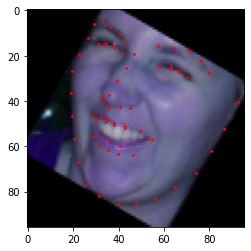

In [14]:
dd = pd.read_csv('train.csv')
sample_idx = 4050
img = cv2.imread(dd['path'][sample_idx])
plt.imshow(img)
plt.scatter(dd.iloc[sample_idx, 1:137:2] ,dd.iloc[sample_idx, 2:137:2], s=3, c='r')

## Save to GDrive

In [ ]:
# !zip -r 300w_96.zip afw_cropped afw_cropped_aug ibug_cropped ibug_cropped_aug helen_train_cropped helen_train_cropped_aug helen_test_cropped helen_test_cropped_aug lfpw_train_cropped lfpw_train_cropped_aug lfpw_test_cropped lfpw_test_cropped_aug train.csv
!zip -r 300w_f_96.zip afw_cropped afw_cropped_aug ibug_cropped helen_train_cropped helen_train_cropped_aug helen_test_cropped lfpw_train_cropped lfpw_train_cropped_aug lfpw_test_cropped train.csv test_ibug.csv test_helen.csv test_lfpw.csv

In [18]:
!mv 300w_f_96.zip /content/gdrive/MyDrive/300cw/